In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [2]:
import config, tools, poor_security, bq_tpc

### Partition and cluster based on time  
The goal is to partition and cluster the database by day. Below, we'll count the values within each column and see where things should be partitioned.

In [3]:
bq = bq_tpc.BQTPC(test="ds",
                  scale=100,
                  cid="01F",
                  desc="dev-debug-01",
                  verbose=True,
                  verbose_query=False)

BigQuery configuration
Service Account:  bq-476262002685@bigquery-encryption.iam.gserviceaccount.com



#### 1. Helper Functions

In [4]:
def count(table, column, distinct=False):
    if distinct:
        distinct = "DISTINCT "
    else:
        distinct = ""
    query_text = "SELECT COUNT({}{}) as r1 FROM {};".format(distinct, table, column)
    return bq.query(query_text=query_text)

In [5]:
def groupby_count(table, column):
    query_text = """
SELECT
  cr_returned_date_sk,
  COUNT(cr_returned_date_sk) as count
FROM `tpc-benchmarking-9432.ds_100GB_01F.catalog_returns`
GROUP BY
  cr_returned_date_sk;
"""


In [6]:
def get_column(table, column):
    query_text = f"SELECT {column} FROM {table};"
    query_result = bq.query(query_text=query_text)
    return query_result.to_dataframe()

In [7]:
def get_table(table):
    query_text = F"SELECT * from {table}"
    query_result = bq.query(query_text=query_text)
    return query_result.to_dataframe()

In [8]:
def get_max(table, column):
    query_text = f"SELECT MAX({column}) FROM {table};"
    query_result = bq.query(query_text=query_text)
    return list(query_result.result())[0][0]

In [9]:
def get_min(table, column):
    query_text = f"SELECT MIN({column}) FROM {table};"
    query_result = bq.query(query_text=query_text)
    return list(query_result.result())[0][0]

#### 2. EDA on TPC-DS  

Loading the 100 GB TPC scale factor data into BigQuery with partitioning or clustering strategy, these are the largest tables (other tables are in the MB range):

| table           | date column         | GB    |
| --------------- | ------------------- | ----- |
| catalog_returns | cr_returned_date_sk | 2.85  |
| catalog_sales   | cs_sold_date_sk     | 36.32 |
| inventory       | inv_date_sk         | 11.75 |
| store_returns   | sr_returned_date_sk | 4.16  |
| store_sales     | ss_solid_date_sk    | 47.32 |
| web_returns     | wr_returned_date_sk | 1.23  |
| web_sales       | ws_sold_date_sk     | 18.23 |

Additionally, for the date columns in these tables, we have the following attributes:
1. All are TPC-DS type `identifier`
2. All are BigQuery type `integer`
3. All have a foreign key of `d_date_sk` in the `date_dim` table

In [10]:
df_dd = get_table("date_dim")

In [11]:
df_dd.head()

,d_date_sk,d_date_id,d_date,d_month_seq,d_week_seq,d_quarter_seq,d_year,d_dow,d_moy,d_dom,d_qoy,d_fy_year,d_fy_quarter_seq,d_fy_week_seq,d_day_name,d_quarter_name,d_holiday,d_weekend,d_following_holiday,d_first_dom,d_last_dom,d_same_day_ly,d_same_day_lq,d_current_day,d_current_week,d_current_month,d_current_quarter,d_current_year
0,2425867,AAAAAAAALAEAFCAA,1929-09-12,356,1550,120,1929,4,9,12,3,1929,120,1550,Thursday,1929Q3,N,N,N,2425856,2426098,2425502,2425776,N,N,N,N,N
1,2425871,AAAAAAAAPAEAFCAA,1929-09-16,356,1550,120,1929,1,9,16,3,1929,120,1550,Monday,1929Q3,N,N,N,2425856,2426098,2425506,2425780,N,N,N,N,N
2,2425870,AAAAAAAAOAEAFCAA,1929-09-15,356,1550,120,1929,0,9,15,3,1929,120,1550,Sunday,1929Q3,N,N,N,2425856,2426098,2425505,2425779,N,N,N,N,N
3,2425866,AAAAAAAAKAEAFCAA,1929-09-11,356,1550,120,1929,3,9,11,3,1929,120,1550,Wednesday,1929Q3,N,N,N,2425856,2426098,2425501,2425775,N,N,N,N,N
4,2425865,AAAAAAAAJAEAFCAA,1929-09-10,356,1550,120,1929,2,9,10,3,1929,120,1550,Tuesday,1929Q3,N,N,N,2425856,2426098,2425500,2425774,N,N,N,N,N


Here, we can see the records are not in chronological order (nor do they need to be)

In [12]:
df_dd.dtypes

d_date_sk               int64
d_date_id              object
d_date                 object
d_month_seq             int64
d_week_seq              int64
d_quarter_seq           int64
d_year                  int64
d_dow                   int64
d_moy                   int64
d_dom                   int64
d_qoy                   int64
d_fy_year               int64
d_fy_quarter_seq        int64
d_fy_week_seq           int64
d_day_name             object
d_quarter_name         object
d_holiday              object
d_weekend              object
d_following_holiday    object
d_first_dom             int64
d_last_dom              int64
d_same_day_ly           int64
d_same_day_lq           int64
d_current_day          object
d_current_week         object
d_current_month        object
d_current_quarter      object
d_current_year         object
dtype: object

In [13]:
df_dd.sort_values(by=["d_year", "d_moy", "d_dom"], inplace=True)
df_dd.reset_index(inplace=True, drop=True)

In [14]:
df_dd.head()

,d_date_sk,d_date_id,d_date,d_month_seq,d_week_seq,d_quarter_seq,d_year,d_dow,d_moy,d_dom,d_qoy,d_fy_year,d_fy_quarter_seq,d_fy_week_seq,d_day_name,d_quarter_name,d_holiday,d_weekend,d_following_holiday,d_first_dom,d_last_dom,d_same_day_ly,d_same_day_lq,d_current_day,d_current_week,d_current_month,d_current_quarter,d_current_year
0,2415022,AAAAAAAAOKJNECAA,1900-01-02,0,1,1,1900,1,1,2,1,1900,1,1,Monday,1900Q1,N,N,Y,2415021,2415020,2414657,2414930,N,N,N,N,N
1,2415023,AAAAAAAAPKJNECAA,1900-01-03,0,1,1,1900,2,1,3,1,1900,1,1,Tuesday,1900Q1,N,N,N,2415021,2415020,2414658,2414931,N,N,N,N,N
2,2415024,AAAAAAAAALJNECAA,1900-01-04,0,1,1,1900,3,1,4,1,1900,1,1,Wednesday,1900Q1,N,N,N,2415021,2415020,2414659,2414932,N,N,N,N,N
3,2415025,AAAAAAAABLJNECAA,1900-01-05,0,1,1,1900,4,1,5,1,1900,1,1,Thursday,1900Q1,N,N,N,2415021,2415020,2414660,2414933,N,N,N,N,N
4,2415026,AAAAAAAACLJNECAA,1900-01-06,0,1,1,1900,5,1,6,1,1900,1,1,Friday,1900Q1,N,Y,N,2415021,2415020,2414661,2414934,N,N,N,N,N


In [15]:
df_dd.tail()

,d_date_sk,d_date_id,d_date,d_month_seq,d_week_seq,d_quarter_seq,d_year,d_dow,d_moy,d_dom,d_qoy,d_fy_year,d_fy_quarter_seq,d_fy_week_seq,d_day_name,d_quarter_name,d_holiday,d_weekend,d_following_holiday,d_first_dom,d_last_dom,d_same_day_ly,d_same_day_lq,d_current_day,d_current_week,d_current_month,d_current_quarter,d_current_year
73044,2488066,AAAAAAAACAHPFCAA,2099-12-28,2399,10435,801,2099,1,12,28,4,2099,801,10435,Monday,2099Q4,N,N,N,2488039,2488372,2487701,2487974,N,N,N,N,N
73045,2488067,AAAAAAAADAHPFCAA,2099-12-29,2399,10436,801,2099,2,12,29,4,2099,801,10436,Tuesday,2099Q4,N,N,N,2488039,2488372,2487702,2487975,N,N,N,N,N
73046,2488068,AAAAAAAAEAHPFCAA,2099-12-30,2399,10436,801,2099,3,12,30,4,2099,801,10436,Wednesday,2099Q4,N,N,N,2488039,2488372,2487703,2487976,N,N,N,N,N
73047,2488069,AAAAAAAAFAHPFCAA,2099-12-31,2399,10436,801,2099,4,12,31,4,2099,801,10436,Thursday,2099Q4,N,N,N,2488039,2488372,2487704,2487977,N,N,N,N,N
73048,2488070,AAAAAAAAGAHPFCAA,2100-01-01,2400,10436,801,2100,4,1,1,1,2100,801,10436,Thursday,2100Q1,Y,N,N,2488070,2488069,2487705,2487978,N,N,N,N,N


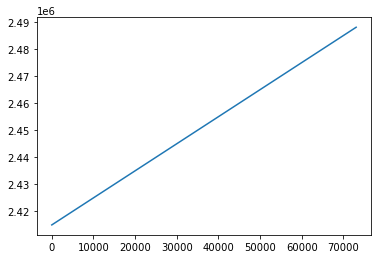

In [16]:
df_dd.d_date_sk.plot();

In [17]:
df_dd.d_date_sk.shape, df_dd.d_date_sk.min(), df_dd.d_date_sk.max()

((73049,), 2415022, 2488070)

So we can conclude there are at most 73,049 dates that the database can hold, ranging from 01-01-1900 to 01-01-2100 and each of those dates can be represented by a single integer starting at 2415022 and ending with 2488070.

### 3. Try calculating a partition strategy  
Look at `catalog_returns` table, `cr_returned_date_sk` column

In [18]:
table = "`tpc-benchmarking-9432.ds_100GB_01F.catalog_returns`"
column = "cr_returned_date_sk"
df = get_column(table=table, column=column)

See how many rows are in the table

In [19]:
df.shape

(14402438, 1)

In [20]:
df.head()

,cr_returned_date_sk
0,2452353
1,2451406
2,2451106
3,2451929
4,2451767


In [21]:
df.tail()

,cr_returned_date_sk
14402433,2451628
14402434,2451036
14402435,2451793
14402436,2452216
14402437,2452096


Plot the count for each unique `cr_returned_date_sk` value

In [22]:
df_vc = df.cr_returned_date_sk.value_counts(sort=True)
df_vc.sort_index(inplace=True)
df_vc = pd.DataFrame({"d_date":df_vc.index, "counts":df_vc.values})

In [23]:
df_vc.iloc[0:5]

,d_date,counts
0,2450821,1
1,2450823,3
2,2450824,2
3,2450825,3
4,2450826,4


In [24]:
df_vc.iloc[-5:]

,d_date,counts
2096,2452918,11
2097,2452919,6
2098,2452920,4
2099,2452921,2
2100,2452922,1


In [25]:
df_vc.iloc[800:810]

,d_date,counts
800,2451622,10999
801,2451623,10732
802,2451624,10875
803,2451625,10839
804,2451626,10834
805,2451627,10940
806,2451628,10784
807,2451629,10785
808,2451630,10799
809,2451631,10758


Let's plot what these sections look like to get a better idea of the distribution of dates in the table.

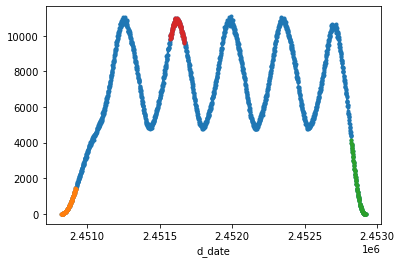

In [26]:
subsets = [df_vc, df_vc.iloc[0:100], df_vc.iloc[-100:], df_vc.iloc[750:850]]
ax = None
for data in subsets:
    ax = data.plot(x="d_date", marker=".", legend=False, ax=ax)

In [27]:
df_dd.head()

,d_date_sk,d_date_id,d_date,d_month_seq,d_week_seq,d_quarter_seq,d_year,d_dow,d_moy,d_dom,d_qoy,d_fy_year,d_fy_quarter_seq,d_fy_week_seq,d_day_name,d_quarter_name,d_holiday,d_weekend,d_following_holiday,d_first_dom,d_last_dom,d_same_day_ly,d_same_day_lq,d_current_day,d_current_week,d_current_month,d_current_quarter,d_current_year
0,2415022,AAAAAAAAOKJNECAA,1900-01-02,0,1,1,1900,1,1,2,1,1900,1,1,Monday,1900Q1,N,N,Y,2415021,2415020,2414657,2414930,N,N,N,N,N
1,2415023,AAAAAAAAPKJNECAA,1900-01-03,0,1,1,1900,2,1,3,1,1900,1,1,Tuesday,1900Q1,N,N,N,2415021,2415020,2414658,2414931,N,N,N,N,N
2,2415024,AAAAAAAAALJNECAA,1900-01-04,0,1,1,1900,3,1,4,1,1900,1,1,Wednesday,1900Q1,N,N,N,2415021,2415020,2414659,2414932,N,N,N,N,N
3,2415025,AAAAAAAABLJNECAA,1900-01-05,0,1,1,1900,4,1,5,1,1900,1,1,Thursday,1900Q1,N,N,N,2415021,2415020,2414660,2414933,N,N,N,N,N
4,2415026,AAAAAAAACLJNECAA,1900-01-06,0,1,1,1900,5,1,6,1,1900,1,1,Friday,1900Q1,N,Y,N,2415021,2415020,2414661,2414934,N,N,N,N,N


In [28]:
df_date_mapper = df_dd[["d_date_sk", "d_date"]].copy()

In [29]:
df_date_mapper["datetime64_ns"] = pd.to_datetime(df_date_mapper.d_date)

In [30]:
df_date_mapper

,d_date_sk,d_date,datetime64_ns
0,2415022,1900-01-02,1900-01-02
1,2415023,1900-01-03,1900-01-03
2,2415024,1900-01-04,1900-01-04
3,2415025,1900-01-05,1900-01-05
4,2415026,1900-01-06,1900-01-06
...,...,...,...
73044,2488066,2099-12-28,2099-12-28
73045,2488067,2099-12-29,2099-12-29
73046,2488068,2099-12-30,2099-12-30
73047,2488069,2099-12-31,2099-12-31


In [31]:
df_date_mapper.d_date_sk.values

array([2415022, 2415023, 2415024, ..., 2488068, 2488069, 2488070])

In [32]:
df_date_mapper.datetime64_ns.values

array(['1900-01-02T00:00:00.000000000', '1900-01-03T00:00:00.000000000',
       '1900-01-04T00:00:00.000000000', ...,
       '2099-12-30T00:00:00.000000000', '2099-12-31T00:00:00.000000000',
       '2100-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [33]:
date_mapper = dict(zip(df_date_mapper.d_date_sk.values,
                       df_date_mapper.datetime64_ns))

In [34]:
df_vc["datetime64_ns"] = df_vc.d_date.apply(lambda x: date_mapper[x])

In [35]:
df_vc.head()

,d_date,counts,datetime64_ns
0,2450821,1,1998-01-07
1,2450823,3,1998-01-09
2,2450824,2,1998-01-10
3,2450825,3,1998-01-11
4,2450826,4,1998-01-12


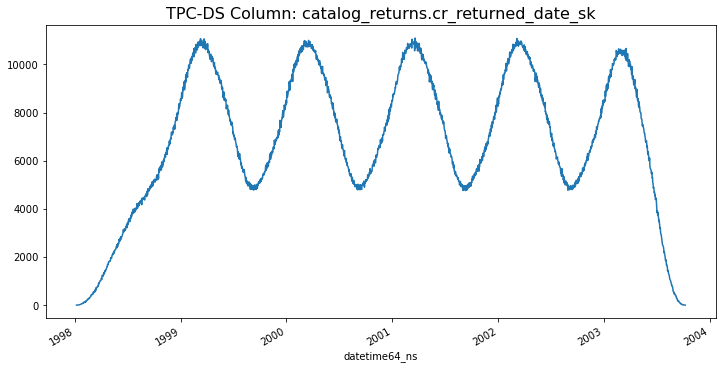

In [36]:
ax = df_vc[["datetime64_ns", "counts"]].plot(x="datetime64_ns", legend=False, figsize=(12,6));
ax.set_title('TPC-DS Column: catalog_returns.cr_returned_date_sk', fontsize=16);

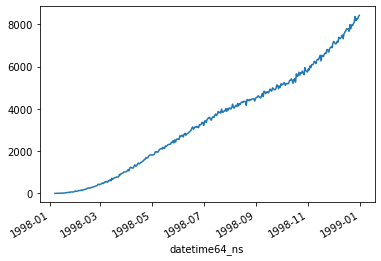

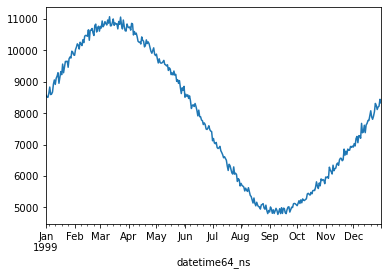

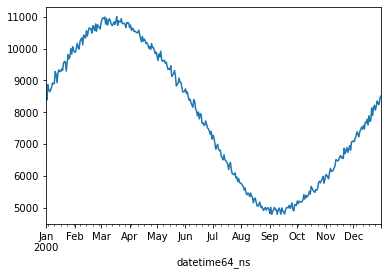

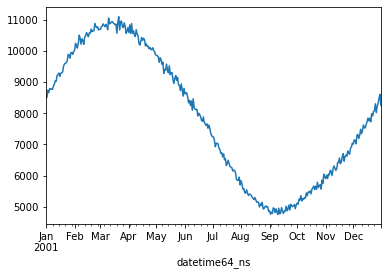

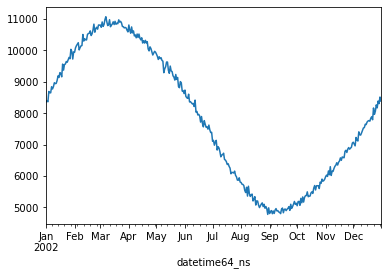

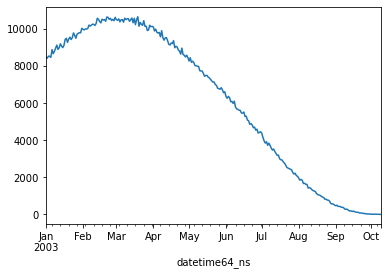

In [37]:
for y in df_vc.datetime64_ns.dt.year.unique():
    df_vc.loc[df_vc.datetime64_ns.dt.year == y, ["datetime64_ns", "counts"]].plot(x="datetime64_ns",
                                                                                  legend=False)

In [38]:
df_vc["month"] = df_vc.datetime64_ns.dt.month

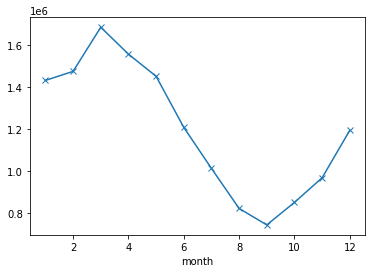

In [39]:
_df_vc = df_vc.groupby(by="month").sum()
_df_vc.reset_index(inplace=True)
_df_vc[["counts", "month"]].plot(x="month", marker="x", legend=False);

In [40]:
df_vc.shape, df_vc.index.min(), df_vc.index.max()

((2101, 4), 0, 2100)

It looks like 2101 partitions, with a span of 1 (which links to 1 day)

Prototype partition statement

In [41]:
f"PARTITION BY RANGE_BUCKET(cr_returned_date_sk, GENERATE_ARRAY({int(df.cr_returned_date_sk.min())}, {df.cr_returned_date_sk.max()}, 1))"

'PARTITION BY RANGE_BUCKET(cr_returned_date_sk, GENERATE_ARRAY(2450821, 2452922, 1))'

### 4. TPC-DS Automate Partition specification

In [42]:
ds_table_columns = [('catalog_returns', 'cr_returned_date_sk'),
                 ('catalog_sales', 'cs_sold_date_sk'),
                 ('inventory', 'inv_date_sk'),
                 ('store_returns', 'sr_returned_date_sk'),
                 ('store_sales', 'ss_sold_date_sk'),
                 ('web_returns', 'wr_returned_date_sk'),
                 ('web_sales', 'ws_sold_date_sk')]
ds_table_columns

[('catalog_returns', 'cr_returned_date_sk'),
 ('catalog_sales', 'cs_sold_date_sk'),
 ('inventory', 'inv_date_sk'),
 ('store_returns', 'sr_returned_date_sk'),
 ('store_sales', 'ss_sold_date_sk'),
 ('web_returns', 'wr_returned_date_sk'),
 ('web_sales', 'ws_sold_date_sk')]

In [45]:
query_list = []
for table, column in ds_table_columns:
    
    table = table = "`tpc-benchmarking-9432.ds_100GB_01F`." + table
    print("Working on Table and Column:")
    print(table, column)
    print()
    
    r_max = get_max(table, column)
    r_min = get_min(table, column)
    
    #df_table = get_column(table=table, column=column)
    
    #print(df_table.dtypes)
    #print("*"*20)
    
    #df_vc = df_table[column].value_counts(sort=True)
    #df_vc.sort_index(inplace=True)
    #df_vc = pd.DataFrame({"d_date":df_vc.index, "counts":df_vc.values})
    
    #ax = df_vc[["d_date", "counts"]].plot(x="d_date", legend=False, figsize=(12,6))
    #ax.set_title(f"TPC-DS 100GB Column: {table}.column", fontsize=16)
    #plt.show();
    
    print("Partitioning SQL:")
    query_text = f"PARTITION BY RANGE_BUCKET({column}, GENERATE_ARRAY({int(r_min)}, {int(r_max)}, 1))"
    query_list.append([table, column, query_text])
    print()
    print(query_text)
    print()
    print("-"*40)

Working on Table and Column:
`tpc-benchmarking-9432.ds_100GB_01F`.catalog_returns cr_returned_date_sk

Partitioning SQL:

PARTITION BY RANGE_BUCKET(cr_returned_date_sk, GENERATE_ARRAY(2450821, 2452922, 1))

----------------------------------------
Working on Table and Column:
`tpc-benchmarking-9432.ds_100GB_01F`.catalog_sales cs_sold_date_sk

Partitioning SQL:

PARTITION BY RANGE_BUCKET(cs_sold_date_sk, GENERATE_ARRAY(2450815, 2452654, 1))

----------------------------------------
Working on Table and Column:
`tpc-benchmarking-9432.ds_100GB_01F`.inventory inv_date_sk

Partitioning SQL:

PARTITION BY RANGE_BUCKET(inv_date_sk, GENERATE_ARRAY(2450815, 2452635, 1))

----------------------------------------
Working on Table and Column:
`tpc-benchmarking-9432.ds_100GB_01F`.store_returns sr_returned_date_sk

Partitioning SQL:

PARTITION BY RANGE_BUCKET(sr_returned_date_sk, GENERATE_ARRAY(2450820, 2452822, 1))

----------------------------------------
Working on Table and Column:
`tpc-benchmar

In [46]:
query_list

[['`tpc-benchmarking-9432.ds_100GB_01F`.catalog_returns',
  'cr_returned_date_sk',
  'PARTITION BY RANGE_BUCKET(cr_returned_date_sk, GENERATE_ARRAY(2450821, 2452922, 1))'],
 ['`tpc-benchmarking-9432.ds_100GB_01F`.catalog_sales',
  'cs_sold_date_sk',
  'PARTITION BY RANGE_BUCKET(cs_sold_date_sk, GENERATE_ARRAY(2450815, 2452654, 1))'],
 ['`tpc-benchmarking-9432.ds_100GB_01F`.inventory',
  'inv_date_sk',
  'PARTITION BY RANGE_BUCKET(inv_date_sk, GENERATE_ARRAY(2450815, 2452635, 1))'],
 ['`tpc-benchmarking-9432.ds_100GB_01F`.store_returns',
  'sr_returned_date_sk',
  'PARTITION BY RANGE_BUCKET(sr_returned_date_sk, GENERATE_ARRAY(2450820, 2452822, 1))'],
 ['`tpc-benchmarking-9432.ds_100GB_01F`.store_sales',
  'ss_sold_date_sk',
  'PARTITION BY RANGE_BUCKET(ss_sold_date_sk, GENERATE_ARRAY(2450816, 2452642, 1))'],
 ['`tpc-benchmarking-9432.ds_100GB_01F`.web_returns',
  'wr_returned_date_sk',
  'PARTITION BY RANGE_BUCKET(wr_returned_date_sk, GENERATE_ARRAY(2450820, 2453001, 1))'],
 ['`tpc-benc

### 5. TPC-H Partitioning  

Loading the 100 GB TPC scale factor data into BigQuery without any partitioning or clustering strategy, these are the largest tables with DATE type columns:

For the date columns in these tables, we have the following attributes:
1. All are TPC-H type `Date`
2. All are BigQuery type `Date`

Given the existing `Date` types in BigQuery with the default loading, the partitioning is straightforward:  

| table    | date column | GB    | Partition Strategy               |
| -------- | ----------- | ----- | -------------------------------- |
| lineitem | l_shipdate  | 79.79 | `PARTITION BY DATE(l_shipdate)`  |
| orders   | o_orderdate | 16.89 | `PARTITION BY DATE(o_orderdate)` |